In [1]:
import numpy as np
import tensorflow as tf

# 0 conv2d demo

In [2]:
from sklearn.datasets import load_sample_images
from matplotlib import pyplot as plt

In [3]:
dataset = np.array(load_sample_images().images, dtype=np.float32)

In [4]:
_,m,n,channel = dataset.shape
dataset.shape

(2, 427, 640, 3)

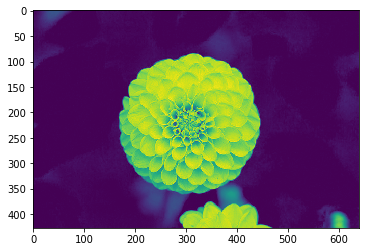

In [5]:
plt.imshow(dataset[1,:,:,0]);
plt.show()

In [6]:
x = tf.placeholder(shape=[None,m,n,channel],dtype=tf.float32,name = 'x')

In [7]:
filters_src = np.zeros([7,7,channel,2])

In [8]:
filters_src[:,3,:,0] = 1;
filters_src[3,:,:,1] = 1

In [9]:
filters = tf.Variable(filters_src,dtype=tf.float32,name = 'w')

In [10]:
conv = tf.nn.conv2d(x,filters,strides=[1,3,3,1],padding='VALID',name='conv')##h =  h+3; w =w +3

In [11]:
max_pool = tf.nn.max_pool(conv,ksize = [1,3,3,1],strides=[1,3,3,1],padding='VALID',name='pool')

In [12]:
init_op = tf.global_variables_initializer()

In [13]:
with tf.Session() as sess:
    sess.run(init_op)
    ##conv
    conv_res,pool_res = sess.run([conv,max_pool],feed_dict={x:dataset})

In [14]:
conv_res.shape

(2, 141, 212, 2)

In [15]:
pool_res.shape

(2, 47, 70, 2)

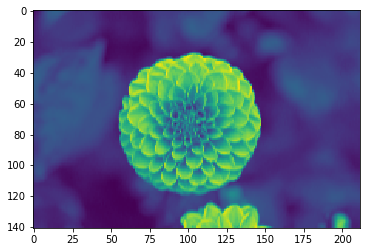

In [16]:
plt.imshow(conv_res[1,:,:,0])
plt.show()

# 1 data

In [17]:
mnist = tf.keras.datasets.mnist

In [18]:
(x_train_src,y_train_src),(x_test_src,y_test_src) = mnist.load_data('./mnist.npz')

In [19]:
print(x_train_src.shape,y_train_src.shape)
print(x_test_src.shape,y_test_src.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [20]:
_,m,n = x_train_src.shape

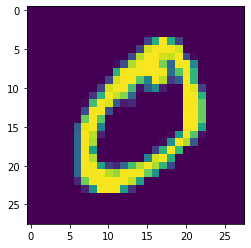

In [21]:
plt.imshow(x_train_src[1,:,:])
plt.show()

# 2 feature

In [22]:
x_train = x_train_src/255.
x_test = x_test_src/255.

In [23]:
y_train = y_train_src
y_test = y_test_src

# 3 model

In [24]:
x = tf.placeholder(shape=[None,m,n],dtype=tf.float32,name='input_x')
re_x = tf.reshape(x,shape=[-1,m,n,1],name = 're_x')

In [25]:
y = tf.placeholder(shape=[None],dtype=tf.int32,name='label_x')

In [26]:
#tf.nn.conv2d?
#tf.nn.relu?
#tf.truncated_normal?

In [27]:
def conv_2d(input_x,name_score,filters,stride,activation = None):
    with tf.name_scope(name_score):
        conv = tf.nn.conv2d(input_x,filter=filters,strides=stride,padding = 'SAME',name = 'conv')
        if 'relu' == activation:
            activ = tf.nn.relu(conv)
        elif 'sigmoid' == activation:
            activ = tf.nn.sigmoid(conv)
        elif 'tanh' == activation:
            activ = tf.nn.tanh(conv)
        else:
            activ = conv
    return conv

In [28]:
filter_1 = tf.Variable(tf.truncated_normal(shape=[5,5,1,20],\
                                           mean=0.0,stddev=tf.sqrt(2.)*tf.sqrt(3/7.*7)),\
                       dtype=tf.float32,name='w1')

In [29]:
stride_1 = [1,1,1,1]

In [30]:
filter_2 = tf.Variable(tf.truncated_normal(shape=[5,5,20,30],\
                                           mean=0.0,stddev=tf.sqrt(2.)*tf.sqrt(3/7.*7)),\
                       dtype=tf.float32,name='w2')

In [31]:
stride_2 = [1,1,1,1]

In [32]:
filter_3 = tf.Variable(tf.truncated_normal(shape=[5,5,30,40],\
                                           mean=0.0,stddev=tf.sqrt(2.)*tf.sqrt(3/7.*7)),\
                       dtype=tf.float32,name='w3')

In [33]:
stride_3 = [1,1,1,1]

In [34]:
#tf.nn.max_pool?

In [35]:
conv1 = conv_2d(re_x,'conv1',filter_1,stride_1,'relu')
maxpool_1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='maxpool1')
print(conv1.shape)
print(maxpool_1.shape)

(?, 28, 28, 20)
(?, 14, 14, 20)


In [36]:
conv2 = conv_2d(maxpool_1,'conv2',filter_2,stride_2,'relu')
maxpool_2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID',name='maxpool2')
print(conv2.shape)
print(maxpool_2.shape)

(?, 14, 14, 30)
(?, 7, 7, 30)


In [37]:
conv3 = conv_2d(maxpool_2,'conv3',filter_3,stride_3,'relu')
print(conv3.shape)

(?, 7, 7, 40)


In [38]:
flat = tf.reshape(conv3,shape=[-1,7*7*40])

In [39]:
w = tf.Variable(tf.truncated_normal(shape=[7*7*40,10],mean=0.0,\
                                    stddev=tf.sqrt(2.0)*tf.sqrt(2.0/(7*7*40+10))),\
                dtype=tf.float32,name='w')

In [40]:
b = tf.Variable(1,dtype=tf.float32,name='bias')

In [41]:
logit = tf.matmul(flat,w)+b

# 4 loss

In [42]:
all_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logit,name = 'all_loss')

In [43]:
loss = tf.reduce_mean(all_loss,name='loss')
print (loss.shape)

()


In [44]:
correct = tf.nn.in_top_k(logit,y,1,name = 'correct')

In [45]:
acc = tf.reduce_mean(tf.cast(correct,tf.float32),name = 'acc')

# 5 optimize

In [46]:
optimize = tf.train.AdamOptimizer(learning_rate=3e-3)

In [47]:
train_op = optimize.minimize(loss)

# 6 init

In [48]:
init_op = tf.global_variables_initializer()

# 7 train

In [49]:
saver = tf.train.Saver()

In [50]:
def fetch_batch(n_epochs,batch_index,batch_size,x_train,y_train):
    beg = (batch_index -1 )*batch_size
    end = batch_index * batch_size
    return x_train[beg:end],y_train[beg:end]

In [54]:
num_epochs = 10
batch_size = 128
num_batch = int(x_train.shape[0]/128) + 1

In [55]:
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(num_epochs):
        for j in range(1,num_batch):
            sample_x,sample_y = fetch_batch(i,j,batch_size,x_train,y_train)
            if j%100 == 0:
                _,loss_train,acc_train = sess.run([train_op,loss,acc],feed_dict={x:sample_x,y:sample_y})
                acc_test = sess.run(acc,feed_dict={x:x_test,y:y_test})
                print('%d\t%d\t%f\t%f\t%f'%(i,j,loss_train,acc_train,acc_test))
            else:
                sess.run(train_op,feed_dict={x:sample_x,y:sample_y})
    saver.save(sess,'./model/cnn')

0	100	1656.580566	0.859375	0.903700
0	200	807.590210	0.937500	0.930300
0	300	1117.900513	0.851562	0.927000
0	400	217.002747	0.960938	0.933300
1	100	254.753616	0.953125	0.941800
1	200	627.114136	0.953125	0.963600
1	300	671.501404	0.929688	0.946100
1	400	56.744492	0.968750	0.957800
2	100	209.711639	0.960938	0.950200
2	200	538.707153	0.960938	0.966900
2	300	263.900391	0.945312	0.962800
2	400	22.286499	0.992188	0.959700
3	100	191.533478	0.976562	0.943600
3	200	699.090576	0.945312	0.966500
3	300	197.722687	0.968750	0.965400
3	400	40.078903	0.976562	0.963300
4	100	103.561554	0.976562	0.956400
4	200	394.360596	0.984375	0.974600
4	300	167.910675	0.953125	0.966800
4	400	70.420990	0.992188	0.967800
5	100	140.190186	0.984375	0.963000
5	200	456.843323	0.968750	0.967500
5	300	225.045273	0.968750	0.968500
5	400	125.212341	0.984375	0.972100
6	100	72.102692	0.984375	0.957100
6	200	427.177734	0.976562	0.973700
6	300	252.723038	0.929688	0.970100
6	400	116.601212	0.976562	0.959700
7	100	165.553345	0.9843

# 8 eval

In [56]:
with tf.Session() as sess:
    saver.restore(sess,'./model/cnn')
    accuary,loss_test,= sess.run([acc,loss],feed_dict={x:x_test,y:y_test})
    print('%f\t%f'%(loss_test,accuary))
    accuary,loss_train,= sess.run([acc,loss],feed_dict={x:x_train,y:y_train})
    print('%f\t%f'%(loss_train,accuary))

INFO:tensorflow:Restoring parameters from ./model/cnn
378.521484	0.970300
152.805069	0.981267
